## According to the salishseacast results what do we expect to see form the 2017 CIOPS results? How does 2017 compare to other years according to the SSC results?

In [19]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

In [6]:
def get_data(mydata, starttime, endtime):
    transports = (mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    temp = (mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])
    salt = (mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])
    return np.sum(transports), temp, salt

In [21]:
dates = [dt.datetime(2016,1,1)+relativedelta(months=i) for i in range(12*5)]

In [8]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720
time = endtime-starttime+1

sum_trans = np.array([])
avg_temp = np.array([])
max_temp = np.array([])
min_temp = np.array([])
avg_salt = np.array([])
max_salt = np.array([])
min_salt = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        tr, te, sa = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        all_total = np.append(all_total, totalT)
        sum_trans = np.append(sum_trans, tr)
        avg_temp = np.append(avg_temp, np.mean(te))
        max_temp = np.append(max_temp, np.max(te))
        min_temp = np.append(min_temp, np.min(te))
        avg_salt = np.append(avg_salt, np.mean(sa))
        max_salt = np.append(max_salt, np.max(sa))
        min_salt = np.append(min_salt, np.min(sa))

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]
        
        tr, te, sa = get_data(mydata, starttime, endtime)

        sum_trans = np.append(sum_trans, tr)
        avg_temp = np.append(avg_temp, np.mean(te))
        max_temp = np.append(max_temp, np.max(te))
        min_temp = np.append(min_temp, np.min(te))
        avg_salt = np.append(avg_salt, np.mean(sa))
        max_salt = np.append(max_salt, np.max(sa))
        min_salt = np.append(min_salt, np.min(sa))
            
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    tr, te, sa = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
    sum_trans = np.append(sum_trans, tr)
    avg_temp = np.append(avg_temp, np.mean(te))
    max_temp = np.append(max_temp, np.max(te))
    min_temp = np.append(min_temp, np.min(te))
    avg_salt = np.append(avg_salt, np.mean(sa))
    max_salt = np.append(max_salt, np.max(sa))
    min_salt = np.append(min_salt, np.min(sa))

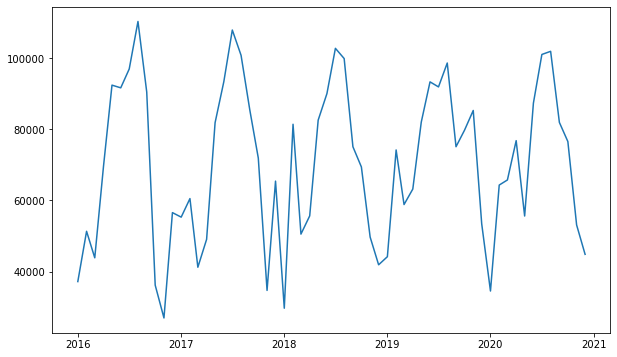

In [25]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, sum_trans)

Text(0, 0.5, 'Temperature $^\\circ C$')

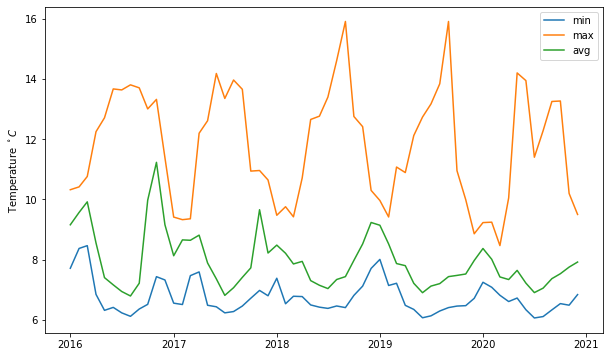

In [28]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_temp, label='min')
ax.plot(dates, max_temp, label='max')
ax.plot(dates, avg_temp, label='avg')
ax.legend()
ax.set_ylabel('Temperature $^\circ C$')

Text(0, 0.5, 'Salinity $g kg^{-1}$')

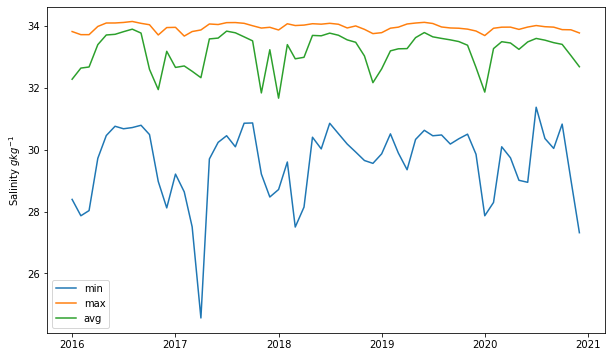

In [29]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.plot(dates, min_salt, label='min')
ax.plot(dates, max_salt, label='max')
ax.plot(dates, avg_salt, label='avg')
ax.legend()
ax.set_ylabel('Salinity $g kg^{-1}$')